### Library Import

In [29]:
import os
import pandas as pd
import numpy as np
import pickle

import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['text.color'] = 'white'#'#aaaaaa'
plt.rcParams.update({'text.color': "white",
                     'axes.labelcolor': "white"})

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorboard.plugins.hparams import api as hp
%load_ext tensorboard

import altair as alt
import seaborn as sns

import importlib

import warnings
warnings.filterwarnings('ignore')


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [39]:
# load in test_train_split custom function
from sklearn.metrics import confusion_matrix
import train
importlib.reload(train)
from train import test_train_split, train_test_model, run
import charts
importlib.reload(charts)
from charts import line_chart, plot_confusion_matrix_2, plot_roc, plot_metrics, plot_images, visualize

# Loading in Images

#### From pickeled files
For loading the images for the model simply run the the below code

In [3]:
# to load image files from pickles both train and test
dir = os.getcwd()

with open('{}/artifacts/{}'.format(dir, 'train_images_pkl.pkl'), 'rb') as pickle_file: #train_images_pkl_all.pkl
    train_data = pickle.load(pickle_file)

with open('{}/artifacts/{}'.format(dir, 'test_images_pkl_w_drone.pkl'), 'rb') as pickle_file: #test_images_pkl_even_ratio.pkl
    test_data = pickle.load(pickle_file)


Now that we have loaded the images we can split the training set in to training, development and test images. We have imported a function that we have created for this. 

In [83]:
#splitting in to test train split for the training data
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(train_data)
print(np.array(train_images).shape)
print(np.array(train_labels).shape)

###############################
#Manual data augmentation flow#
###############################

#FLIPPING
augmented_train_images = []
augmented_train_labels = []
for i in range(len(train_images)):
    augmented_train_images.append(tf.image.flip_left_right(train_images[i]))
    augmented_train_labels.append(train_labels[i])
    # flipped = tf.image.flip_left_right(image, 0.4)
    # visualize(image, flipped)

train_images = tuple(list(train_images) + augmented_train_images)
train_labels = train_labels + tuple(augmented_train_labels)

#SATURATION
# saturated_train_images = []
# saturated_train_labels = []
# for i in range(len(train_images)):
#     saturated_train_images.append(tf.image.adjust_saturation(train_images[i], 2))
#     saturated_train_labels.append(train_labels[i])


# train_images = tuple(list(train_images) + saturated_train_images)
# train_labels = train_labels + tuple(saturated_train_labels)

# #BRIGHTNESS
# bright_train_images = []
# bright_train_labels = []
# for i in range(len(train_images)):
#     bright_train_images.append(tf.image.adjust_brightness(train_images[i], 0.4))
#     bright_train_labels.append(train_labels[i])

# train_images = tuple(list(train_images) + bright_train_images)
# train_labels = train_labels + tuple(bright_train_labels)

# #CONTRAST
# contrast_train_images = []
# contrast_train_labels = []
# for i in range(len(train_images)):
#     contrast_train_images.append(tf.image.adjust_contrast(train_images[i], 0.4))
#     contrast_train_labels.append(train_labels[i])

# train_images = tuple(list(train_images) + contrast_train_images)
# train_labels = train_labels + tuple(contrast_train_labels)



#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0

# print(train_images.shape)
# print(train_labels.shape)

train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

input_shape = train_images.shape[1:]
# print(input_shape)
# print(train_images.shape)
# print(train_labels.shape)

(1516, 100, 177, 3)
(1516, 1)
(3032, 100, 177, 3)
(100, 177, 3)
(3032, 100, 177, 3)
(3032, 1)


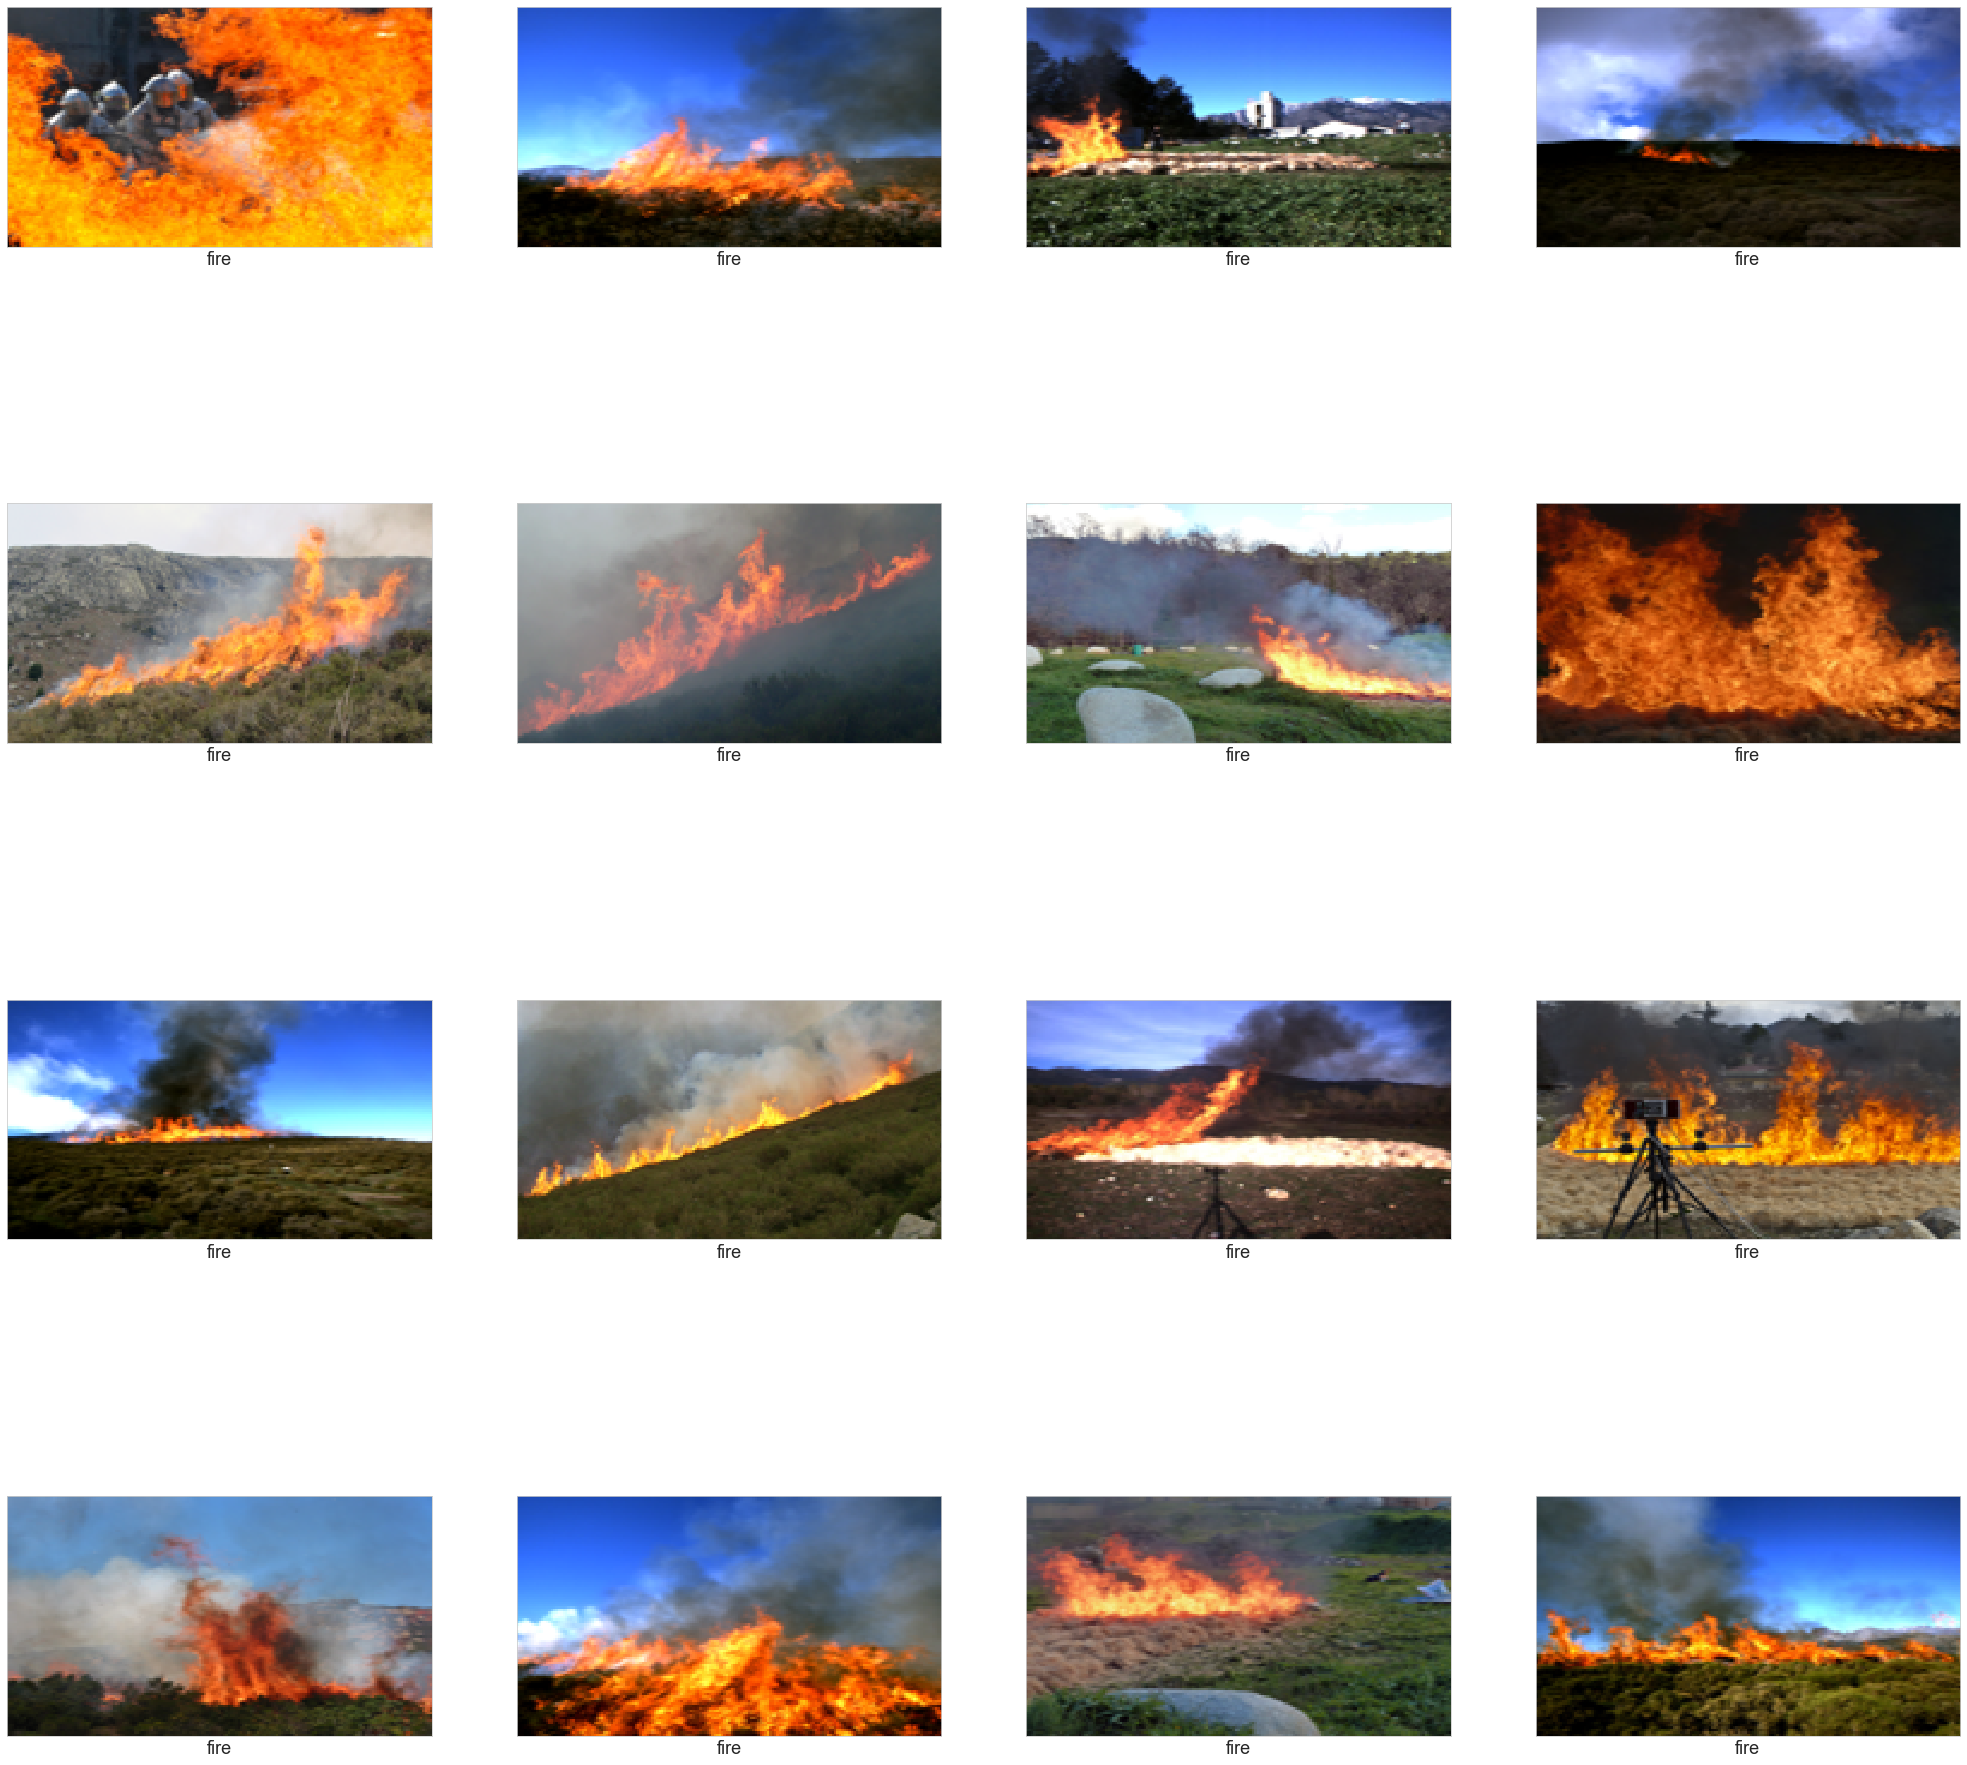

In [123]:
hold_out_images, hold_out_labels = zip(*test_data)

#normalize the images
hold_out_images = np.array(hold_out_images) / 255.0

augmented_hold_out_images = []
augmented_hold_out_labels = []
for i in range(len(hold_out_images)):
    augmented_hold_out_images.append(tf.image.flip_left_right(hold_out_images[i]))
    augmented_hold_out_labels.append(hold_out_labels[i])

hold_out_images = tuple(list(hold_out_images) + augmented_hold_out_images)
hold_out_labels = hold_out_labels + tuple(augmented_hold_out_labels)

hold_out_images = tf.convert_to_tensor(hold_out_images , dtype=tf.float32)
input_shape = hold_out_images.shape[1:]

# print(hold_out_images.shape)
# print(hold_out_images.shape)
# print(input_shape)
plot_images(hold_out_images, hold_out_labels)

# Hyperparameter Tuning

In [85]:
%reload_ext tensorboard
#! rm -rf ./logs/

In [119]:
session_num = 0
epochs = 25
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16,32,64]))#, 64])) #8, 16
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.5))
# dropout_rate = 0.3
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['RMSprop','adam','Nadam']))#,'adam', 'Nadam'])) #'sgd','Adagrad','RMSprop',

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []
aucs = []
cms = []
units = []
dropouts = []
optimizers = []
histories = []
modelz = []
predictions = []

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
    for optimizer in HP_OPTIMIZER.domain.values:
        hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
        }
        run_name = "run-%d" % session_num
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        units.append(num_units)
        dropouts.append(dropout_rate)
        optimizers.append(optimizer)
        model = run('logs/hparam_tuning/' + run_name, hparams, epochs, input_shape,train_images,train_labels,test_images, test_labels,
                HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER, predictions,
                params, losses, accuracies, f1_scores, precisions, recalls, cms, aucs,
                units, dropouts, optimizers, histories, augmentModel=True)
        modelz.append(model)
        session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'Nadam'}
Epoch 1/25
95/95 [==============================] - 44s 449ms/step - loss: 0.9298 - accuracy: 0.6487 - f1_m: 0.6629 - precision_m: 0.5866 - recall_m: 0.8044 - val_loss: 0.6074 - val_accuracy: 0.7421 - val_f1_m: 0.7550 - val_precision_m: 0.6084 - val_recall_m: 1.0000
Epoch 2/25
95/95 [==============================] - 41s 429ms/step - loss: 0.4569 - accuracy: 0.8104 - f1_m: 0.7209 - precision_m: 0.5764 - recall_m: 0.9756 - val_loss: 0.3309 - val_accuracy: 0.8632 - val_f1_m: 0.7319 - val_precision_m: 0.5860 - val_recall_m: 0.9824
Epoch 3/25
95/95 [==============================] - 39s 413ms/step - loss: 0.2860 - accuracy: 0.8882 - f1_m: 0.7224 - precision_m: 0.5730 - recall_m: 0.9905 - val_loss: 0.2967 - val_accuracy: 0.8947 - val_f1_m: 0.7403 - val_precision_m: 0.5903 - val_recall_m: 1.0000
Epoch 4/25
95/95 [==============================] - 39s 412ms/step - loss: 0.2192 - accuracy: 0.9218 - f1_m: 0.7200 -

In [120]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

modelDf = pd.DataFrame(list(zip(units, dropouts, optimizers, losses, accuracies, f1_scores, precisions, recalls, cms)),#aucs, 
               columns =['units', 'dropouts', 'optimizers', 'losses', 'accuracies', 'f1_scores', 'precisions', 'recalls', 'cms'])#'aucs',
modelDf

,units,dropouts,optimizers,losses,accuracies,f1_scores,precisions,recalls,cms
0,16,0.1,Nadam,0.042292,0.989474,0.740310,0.590278,1.0,"[[77, 1], [1, 111]]"
1,16,0.1,RMSprop,0.517241,0.915789,0.740310,0.590278,1.0,"[[78, 0], [16, 96]]"
2,16,0.1,adam,0.046101,0.984211,0.740310,0.590278,1.0,"[[76, 2], [1, 111]]"
3,16,0.5,Nadam,0.092023,0.963158,0.740310,0.590278,1.0,"[[71, 7], [0, 112]]"
4,16,0.5,RMSprop,0.098793,0.957895,0.740310,0.590278,1.0,"[[73, 5], [3, 109]]"
5,16,0.5,adam,0.123653,0.963158,0.740310,0.590278,1.0,"[[75, 3], [4, 108]]"
6,32,0.1,Nadam,0.044679,0.978947,0.740310,0.590278,1.0,"[[75, 3], [1, 111]]"
7,32,0.1,RMSprop,0.133045,0.952632,0.740310,0.590278,1.0,"[[75, 3], [6, 106]]"
8,32,0.1,adam,0.161555,0.947368,0.740310,0.590278,1.0,"[[76, 2], [8, 104]]"
9,32,0.5,Nadam,0.089279,0.973684,0.740310,0.590278,1.0,"[[75, 3], [2, 110]]"


In [ ]:
#Best so far

# 70 TN / 13 FN / 2 FP / 57 TP -- adam / 32 units / 0.2 dropout / 10 epochs
# 54 TN / 11 FN / 18 FP / 59 TP -- Nadam / 32 units / 0.3 dropout / 10 epochs
# 35 TN / 12 FN / 37 FP / 58 TP -- adam / 16 units / 0.1 dropout / 25 epochs
# 40 TN / 17 FN / 32 FP / 53 TP -- RMSprop / 16 units / 0.5 dropout / 25 epochs

In [108]:
model = modelz[8]

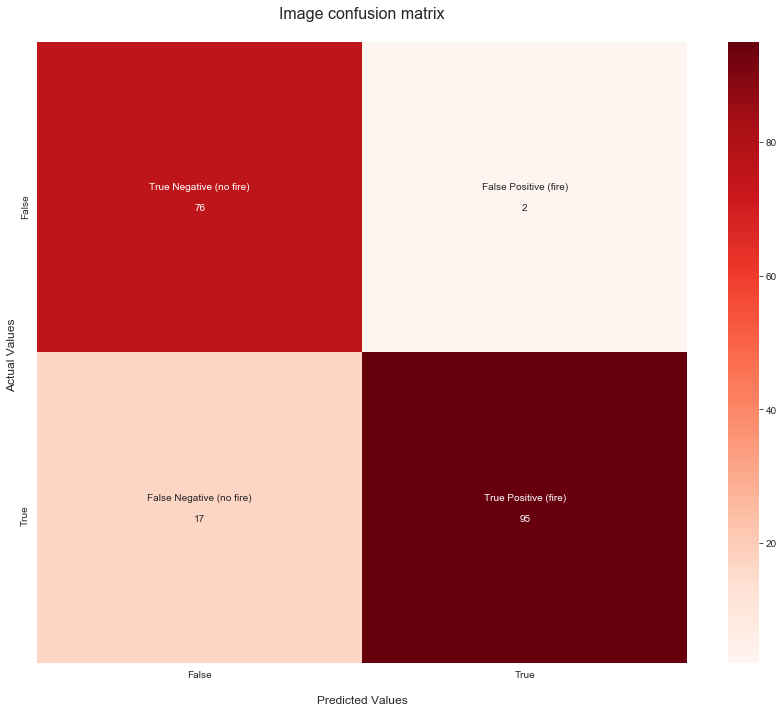

In [109]:

modelDf['cms'].values[11]

plot_confusion_matrix_2(modelDf['cms'].values[11],normalize=False)

In [121]:
# prediction = model.predict(x=test_images, steps=len(test_images), verbose=0)
# cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(prediction, axis=-1))
# print(np.argmax(prediction, axis=-1).shape)
# print(test_labels.shape)
cm2s=[]
for model in modelz:
    predictions2 = model.predict(x=hold_out_images, steps=len(hold_out_images), verbose=0)
    cm2 = confusion_matrix(y_true=hold_out_labels, y_pred=np.argmax(predictions2, axis=-1))
    cm2s.append(cm2)
# print(np.argmax(predictions2, axis=-1).shape)
# print(test_data_labels.shape)

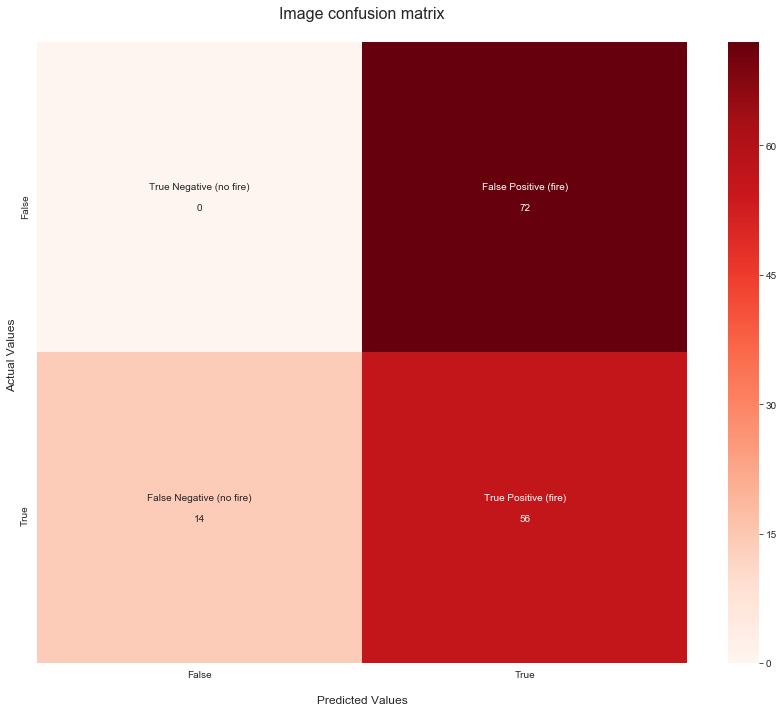

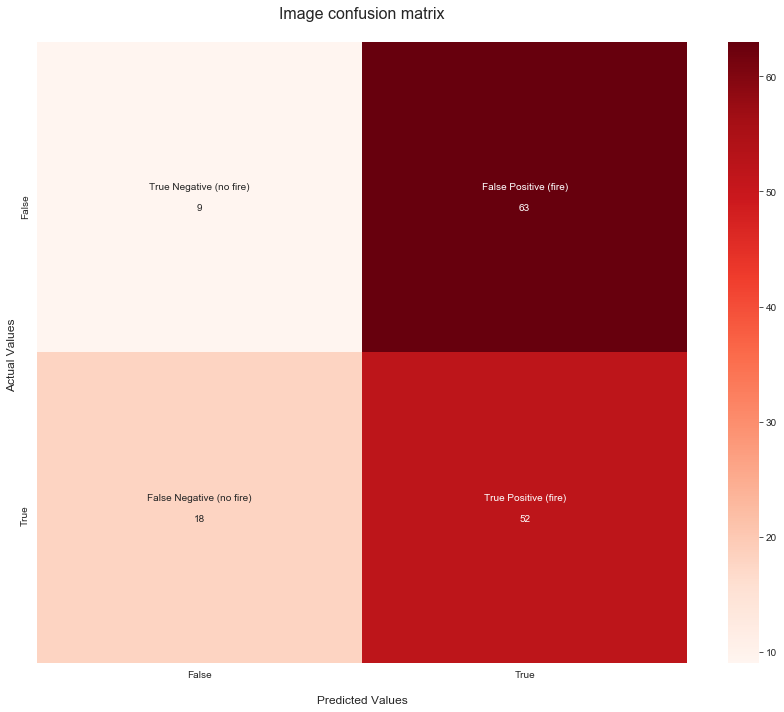

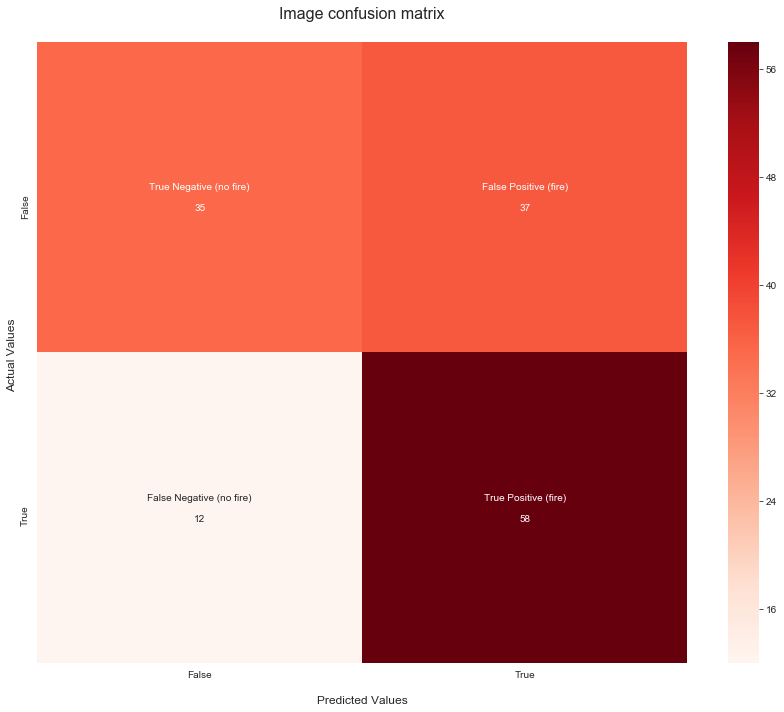

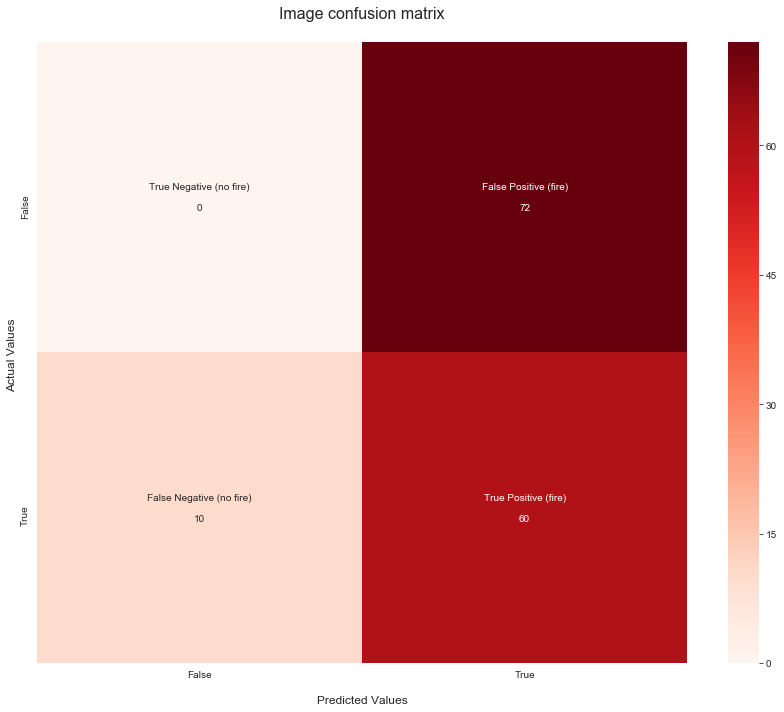

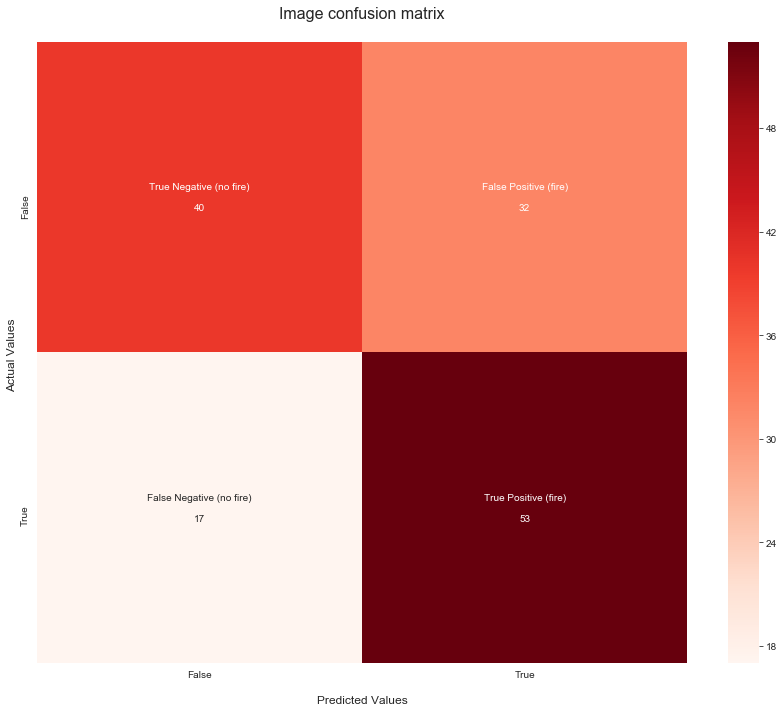

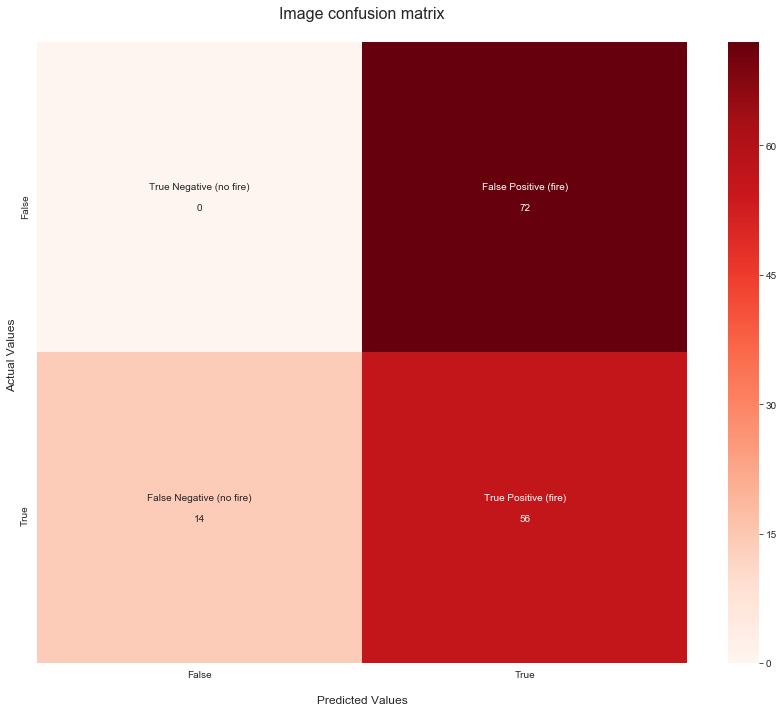

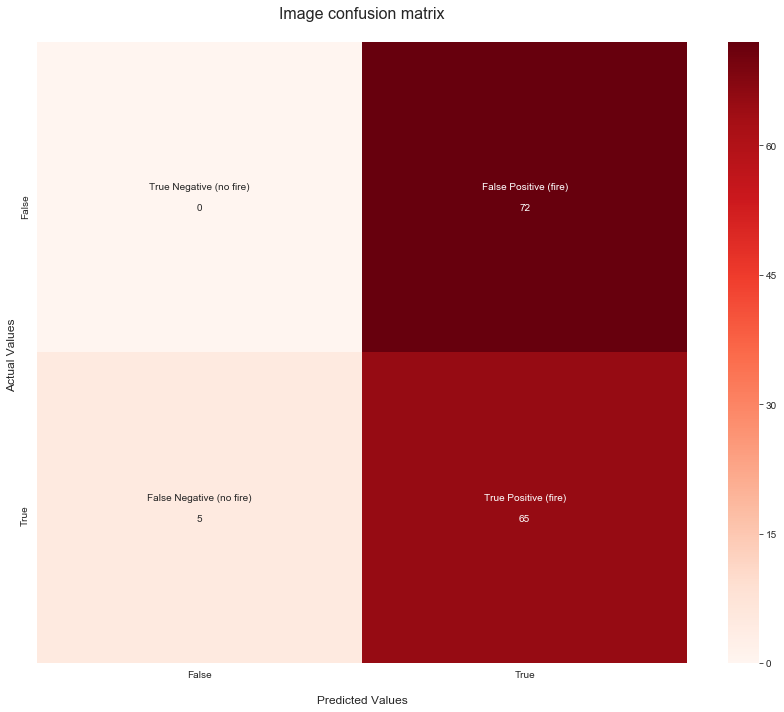

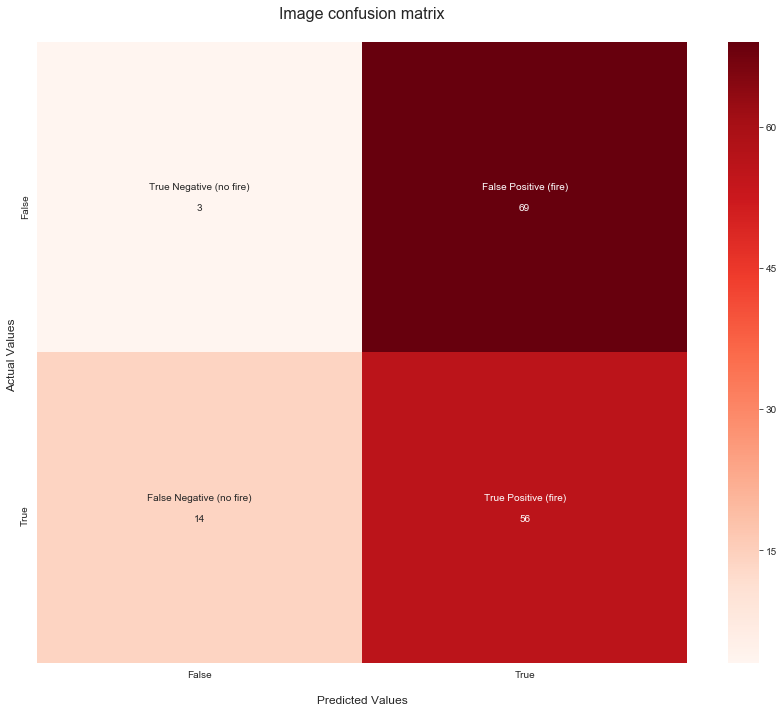

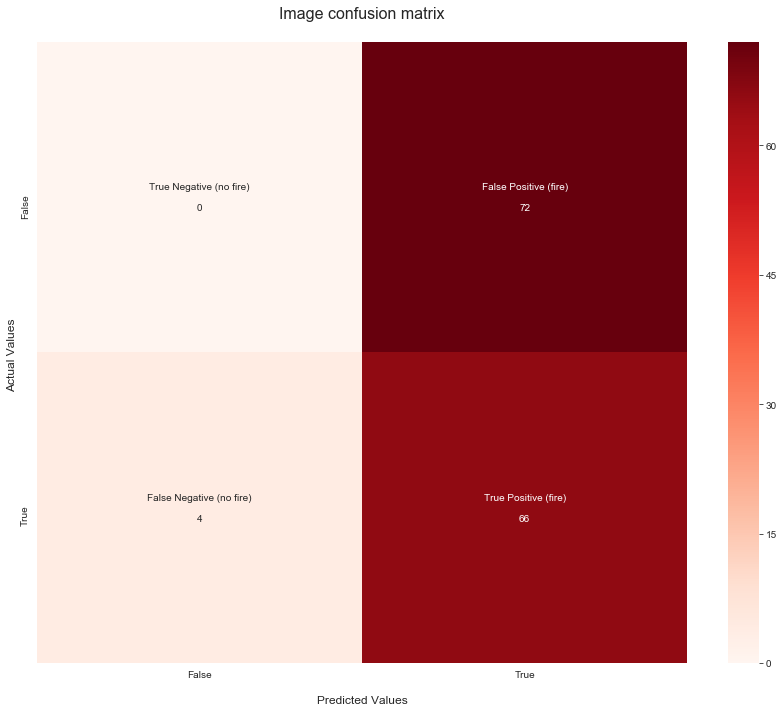

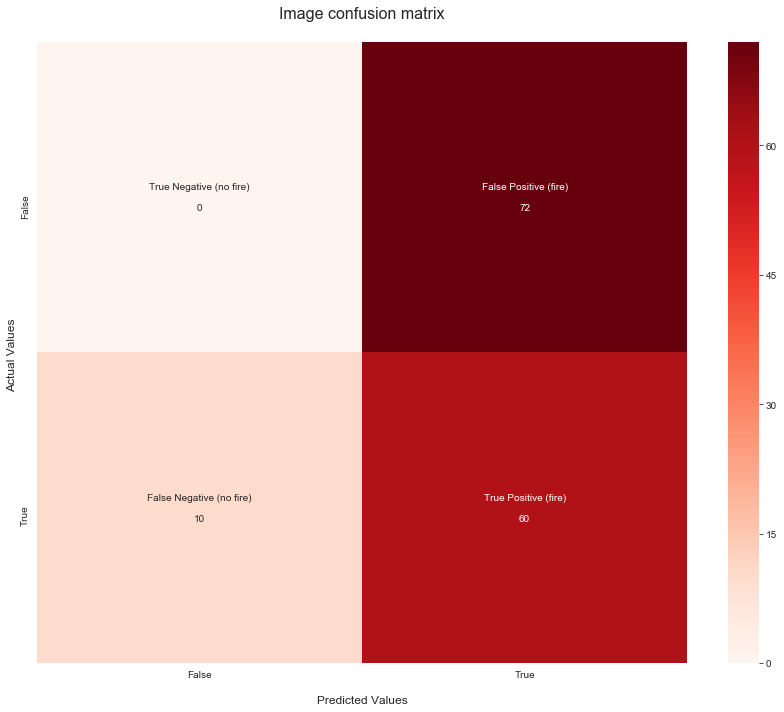

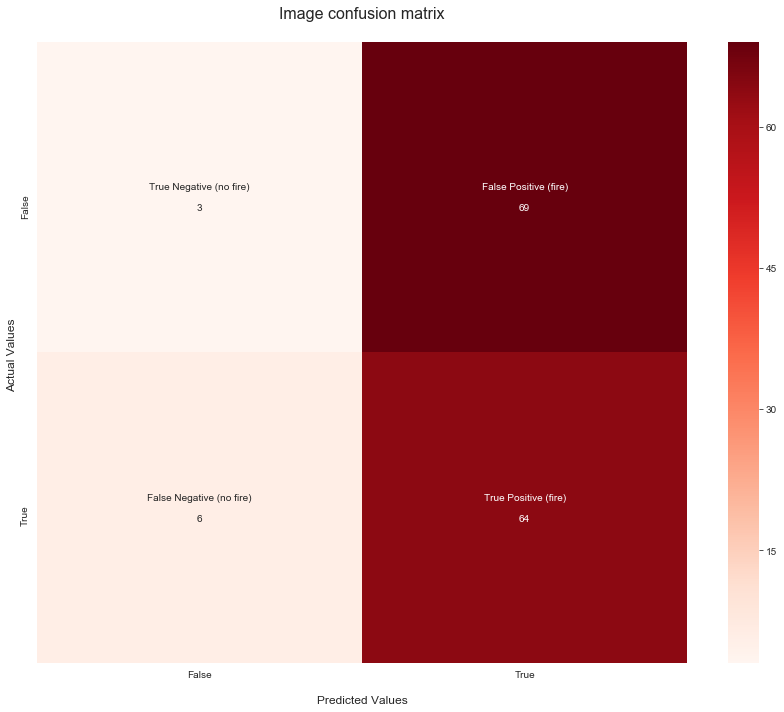

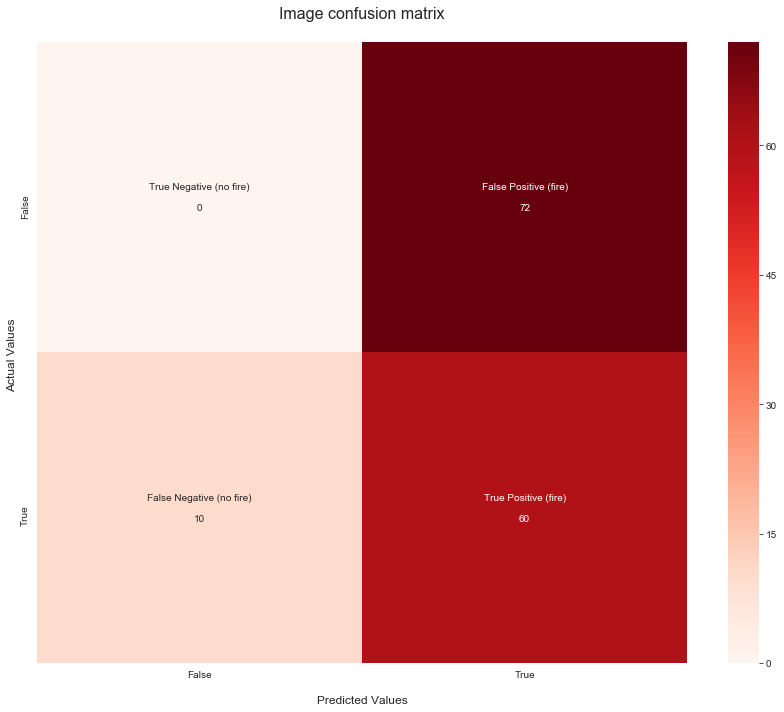

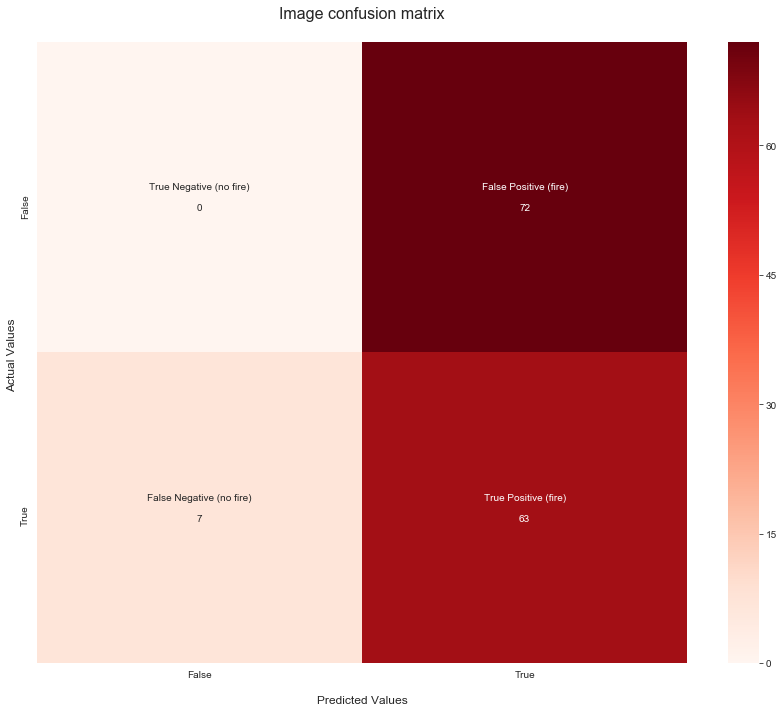

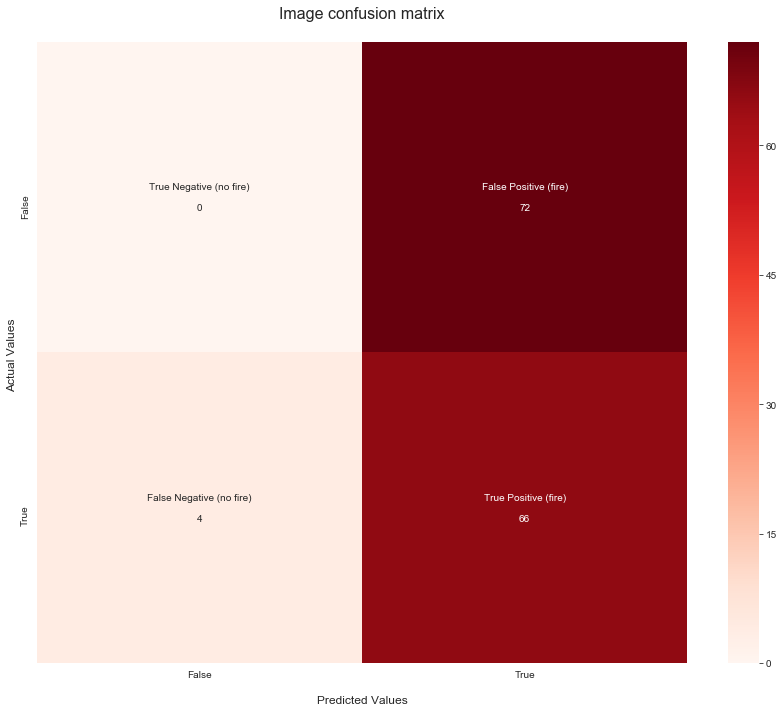

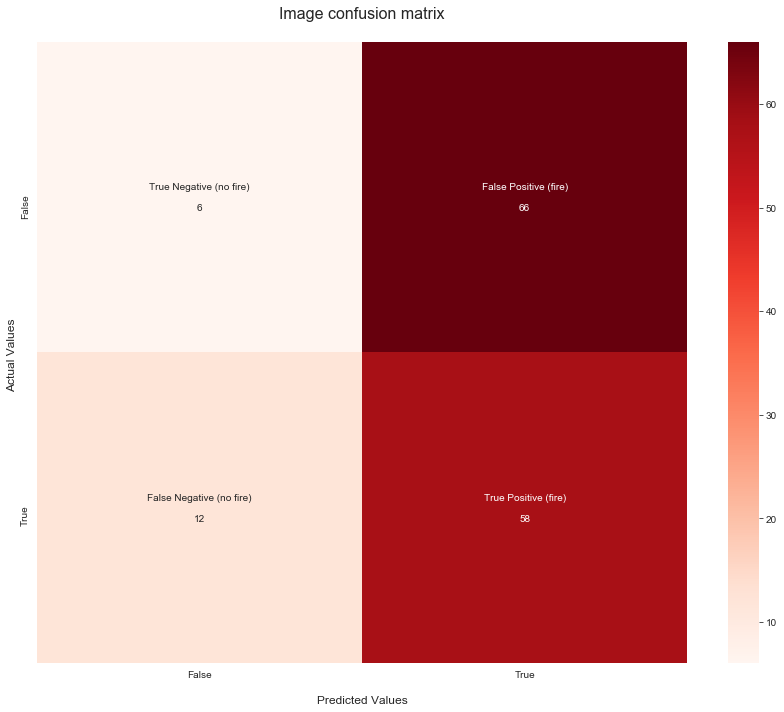

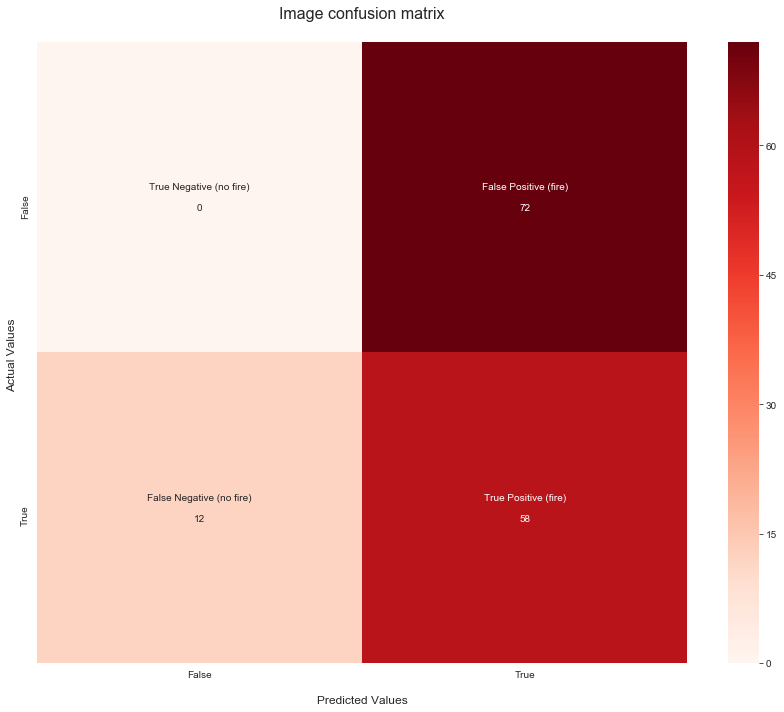

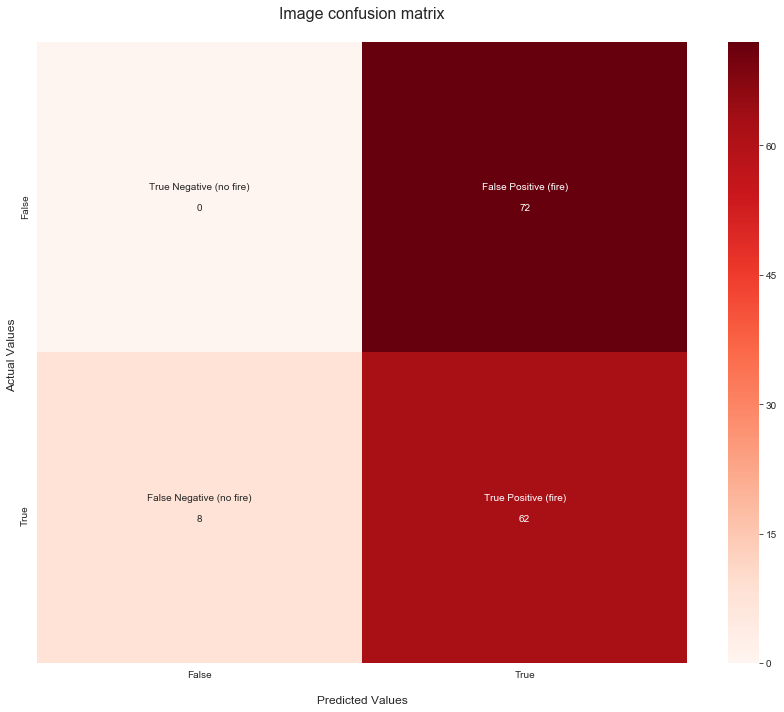

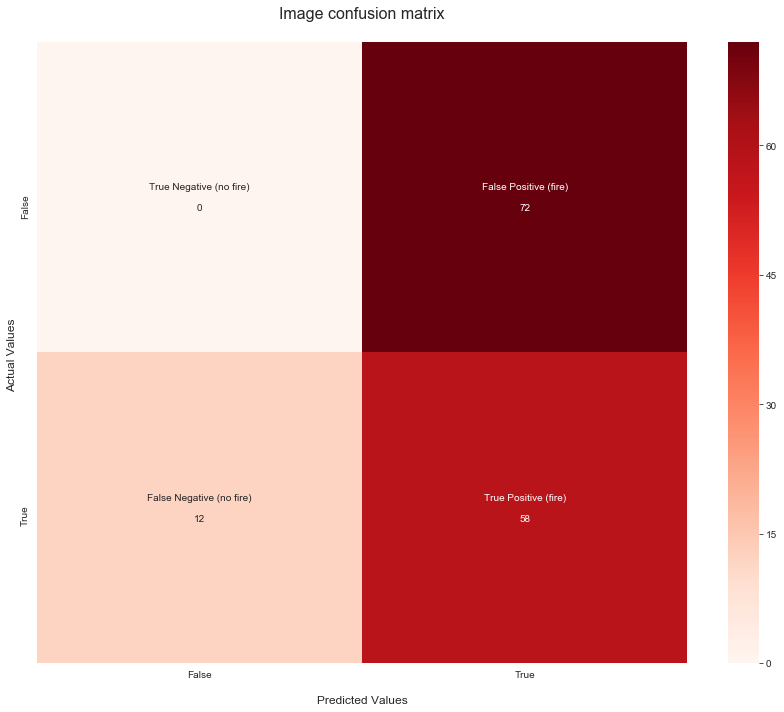

In [122]:

# modelDf['test_cms'].values[0]
# plot_confusion_matrix_2(modelDf['test_cms'].values[0],normalize=False)
for cm2 in cm2s:
    plot_confusion_matrix_2(cm2,normalize=False)

In [ ]:

history_df = pd.DataFrame(histories[0].history).reset_index()
history_df

,index,loss,accuracy,f1_m,precision_m,recall_m
0,0,0.70714,0.550792,0.7145,0.568331,0.982416


In [32]:
model.save("artifacts/model_20211201.h5")

In [ ]:
line_chart(history_df)

In [ ]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

# for i in range(len(list(modelDf.optimizers))):
#     cls = modelDf.iloc[i,2]
#     plot_confusion_matrix_2(modelDf[modelDf['optimizers']==cls]['cms'][i])
#     ax.title.set_text(type(cls).__name__)
# plt.tight_layout()  
# plt.show()

In [ ]:
# train_predictions_baseline = model.predict(train_images)
# test_predictions_baseline = model.predict(test_images)
plot_roc("Train Baseline", train_labels, predictions[0], color=colors[0])
plot_roc("Test Baseline", hold_out_labels, predictions2, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [ ]:
plot_metrics(history)